In [1]:
#biblioteca que utilizaremos nesse projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df_gdp = pd.read_csv("gdp.csv")
df_obesity = pd.read_csv("obesity2.csv")

In [3]:
df_gdp.head()

Country                                         Region      Year  \
0  Afghanistan  Middle East, North Africa, and Greater Arabia  1/1/1901   
1  Afghanistan  Middle East, North Africa, and Greater Arabia  1/1/1906   
2  Afghanistan  Middle East, North Africa, and Greater Arabia  1/1/1911   
3  Afghanistan  Middle East, North Africa, and Greater Arabia  1/1/1916   
4  Afghanistan  Middle East, North Africa, and Greater Arabia  1/1/1921   

    GDP_pp   
0   613.99   
1   624.04   
2   634.25   
3   647.28   
4   662.40

In [4]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4419 entries, 0 to 4418
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Country   4419 non-null   object
 1   Region    4419 non-null   object
 2   Year      4419 non-null   object
 3    GDP_pp   4419 non-null   object
dtypes: object(4)
memory usage: 138.2+ KB


### Iniciando a limpeza dos dados

In [6]:
#transformando a coluna Year em formato numérico
df_gdp['Year'] = pd.to_datetime(df_gdp['Year'], format='%d/%m/%Y')

In [7]:
#como apenas o ano é importante nessa coluna, vou deixar apenas com o ano.
df_gdp['Year'] = df_gdp['Year'].dt.year

In [8]:
#transformando a coluna Year em int
df_gdp['Year'] = df_gdp['Year'].astype(int)

In [9]:
#renomenado a coluna GDP_pp para retirar os espaços vazios
df_gdp = df_gdp.rename(columns={' GDP_pp ': 'GDP'})

In [10]:
#transformando a coluna GDP em dados do tipo float
df_gdp['GDP'] = df_gdp['GDP'].str.replace(',', '')
df_gdp['GDP'] = df_gdp['GDP'].astype(float)

In [11]:
#conferindo se temos linhas vazias, resultados = 0 e afins
df_gdp["GDP"].value_counts()

GDP
3372.76    4
959.19     2
1084.20    2
745.46     2
6289.83    2
          ..
1246.93    1
1272.71    1
1299.02    1
1350.79    1
526.33     1
Name: count, Length: 4387, dtype: int64

### Agora com os dados convertidos e tratados, podemos começar nossas análises.

In [13]:
#primeira entrada dos países. Todos tem dados de 1901 em diante, exceto kosovo, que começa em 1991
df_gdp.groupby("Country")["Year"].min()

Country
Afghanistan    1901
Albania        1901
Algeria        1901
Andorra        1901
Angola         1901
               ... 
Venezuela      1901
Vietnam        1901
Yemen, Rep.    1901
Zambia         1901
Zimbabwe       1901
Name: Year, Length: 193, dtype: int32

In [14]:
#comparando o crescimento percentual do começo ao final do século passado
df_start = df_gdp[df_gdp["Year"] == 1901]
df_end = df_gdp[df_gdp["Year"] == 1996]


In [15]:
((df_end.groupby("Region")["GDP"].mean() / df_start.groupby("Region")["GDP"].mean() - 1) * 100).sort_values()

Region
Sub-Saharan Africa                               248.633780
South America                                    312.123735
Australia and Oceania                            396.075383
Central America and the Caribbean                406.426789
North America                                    589.760175
Europe                                           594.046167
Asia                                             711.761516
Middle East, North Africa, and Greater Arabia    857.215950
Name: GDP, dtype: float64

### Trabalhando o data frame para podermos comparar com os dados de outro data set

In [17]:
#criando as linhas faltantes
df_gdp = (df_gdp.set_index('Year') # Torna a coluna Year como índice
.groupby(['Country', 'Region'])['GDP'] # Agrupa os dados usando como referência Country e Region, e seleciona a coluna GDP_pp
.apply(lambda x: x.reindex(range(x.index.min(), x.index.max() + 1)) # Usa o método reindex para criar os índices faltantes (usando o menor e maior índice como limites)
.interpolate(method='linear')) # Interpola a coluna GDP, de modo a manter os dados existentes e criar os faltantes
.reset_index()
)

#Dessa forma nós conseguimos criar linhas e preencher o dado de GDP com uma estimativa de crescimento linear.

In [18]:
#Visualizando os dados do Brasil
df_gdp[df_gdp["Country"] == "Brazil"]

Country         Region  Year        GDP
2553  Brazil  South America  1901    648.480
2554  Brazil  South America  1902    658.178
2555  Brazil  South America  1903    667.876
2556  Brazil  South America  1904    677.574
2557  Brazil  South America  1905    687.272
...      ...            ...   ...        ...
2659  Brazil  South America  2007   9150.558
2660  Brazil  South America  2008   9458.686
2661  Brazil  South America  2009   9766.814
2662  Brazil  South America  2010  10074.942
2663  Brazil  South America  2011  10383.070

[111 rows x 4 columns]

<Axes: xlabel='Year', ylabel='GDP'>

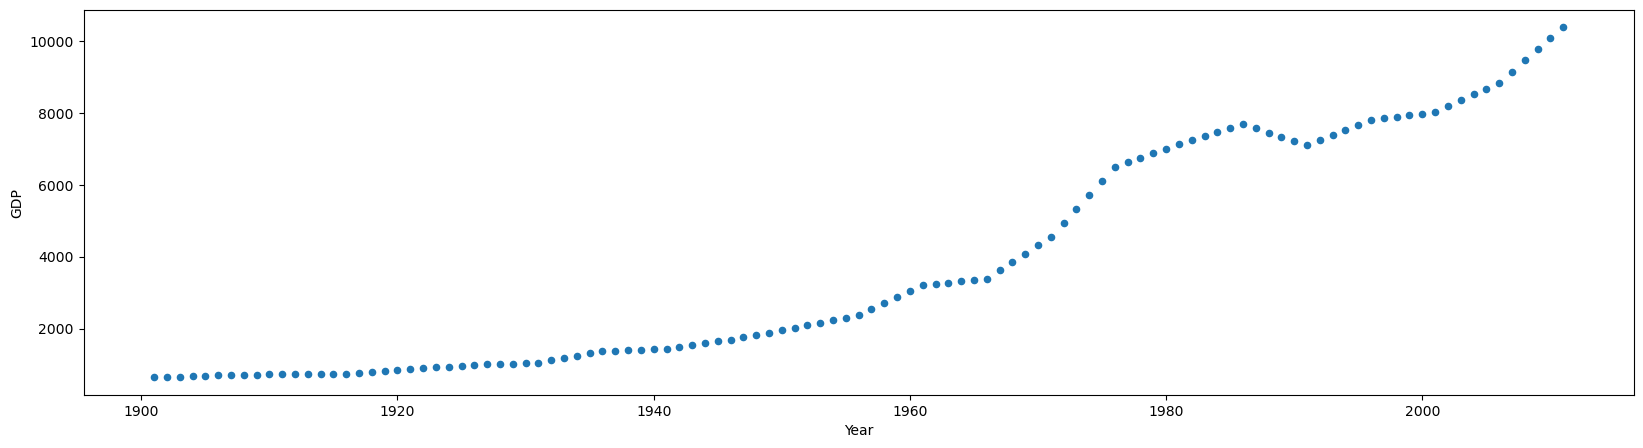

In [19]:
#plotando um gráfico de pontos para avaliarmos a distribuição dos dados estimados
fig, ax = plt.subplots(figsize=(20,5))

df_gdp[df_gdp["Country"] == "Brazil"].plot(kind="scatter", y="GDP", x="Year", ax=ax)

#Podemos ver que o comportamento dos pontos está de acordo com o que imaginavamos, e que esses dados são confiáveis

In [20]:
#criando as colunas necessárias para plotar o gráfico de visualização do pib ao redor do mundo por ano
df = px.data.gapminder()
dict_iso_alpha = df.set_index("country").to_dict()["iso_alpha"]
dict_num = {j: i for i, j in enumerate(df_gdp["Country"].unique())}
df_gdp["iso_alpha"] = df_gdp['Country'].map(dict_iso_alpha)
df_gdp["iso_num"] = df_gdp['Country'].map(dict_num)

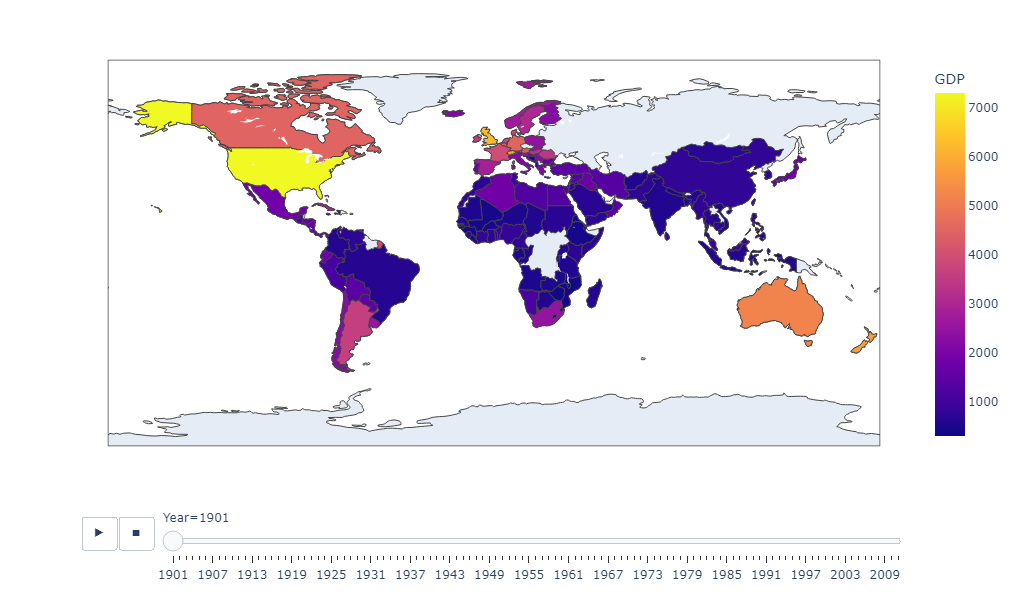

In [21]:
#plotando um gráfico para avaliarmos o crescimento do pib ao redor do mundo
fig = px.choropleth(df_gdp
.reset_index(drop=True)
, locations="iso_alpha"
, color="GDP"
, hover_name = "Country"
, animation_frame = "Year")

fig.update_layout(height=600)
fig.show()


In [22]:
df_obesity = df_obesity.drop("Unnamed: 0", axis=1)
df_obesity

Country  Year         Sex  Obesity
0      Afghanistan  1975  Both sexes      0.5
1      Afghanistan  1975        Male      0.2
2      Afghanistan  1975      Female      0.8
3      Afghanistan  1976  Both sexes      0.5
4      Afghanistan  1976        Male      0.2
...            ...   ...         ...      ...
24061     Zimbabwe  2015        Male      4.5
24062     Zimbabwe  2015      Female     24.8
24063     Zimbabwe  2016  Both sexes     15.5
24064     Zimbabwe  2016        Male      4.7
24065     Zimbabwe  2016      Female     25.3

[24066 rows x 4 columns]

In [23]:
df_obesity["Year"] = df_obesity["Year"].astype(str)

In [24]:
df_obesity["Country - Year"] = df_obesity["Country"] + " - " + df_obesity["Year"]

In [25]:
df_obesity["Year"] = df_obesity["Year"].astype(int)

In [26]:
df_obesity = df_obesity[df_obesity["Sex"] == "Both sexes"]

In [27]:
df_gdp.head()

Country                                         Region  Year     GDP  \
0  Afghanistan  Middle East, North Africa, and Greater Arabia  1901  613.99   
1  Afghanistan  Middle East, North Africa, and Greater Arabia  1902  616.00   
2  Afghanistan  Middle East, North Africa, and Greater Arabia  1903  618.01   
3  Afghanistan  Middle East, North Africa, and Greater Arabia  1904  620.02   
4  Afghanistan  Middle East, North Africa, and Greater Arabia  1905  622.03   

  iso_alpha  iso_num  
0       AFG        0  
1       AFG        0  
2       AFG        0  
3       AFG        0  
4       AFG        0

In [28]:
df_gdp["Year"] = df_gdp["Year"].astype(str)

In [29]:
df_gdp["Country - Year"] = df_gdp["Country"] + " - " + df_gdp["Year"]

In [30]:
df_gdp["Year"] = df_gdp["Year"].astype(int)

In [31]:
df_final = pd.merge(df_gdp, df_obesity[["Obesity", "Country - Year"]], left_on="Country - Year", right_on="Country - Year")

In [32]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5984 entries, 0 to 5983
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         5984 non-null   object 
 1   Region          5984 non-null   object 
 2   Year            5984 non-null   int32  
 3   GDP             5984 non-null   float64
 4   iso_alpha       4329 non-null   object 
 5   iso_num         5984 non-null   int64  
 6   Country - Year  5984 non-null   object 
 7   Obesity         5984 non-null   float64
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 350.8+ KB


In [33]:
df_final.set_index("Country - Year", inplace=True)

In [34]:
df_final["Obesity"].isnull().sum()

0

In [35]:
df_final["GDP"].isnull().sum()

0

In [36]:
df_final.groupby("Year")[["Obesity","GDP"]].mean().corr()

Obesity       GDP
Obesity  1.000000  0.945287
GDP      0.945287  1.000000